In [1]:
# !pip install lime
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import layers, models
import torch
from tqdm import tqdm
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import lime
import lime.lime_tabular
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import shap
import tensorflow as tf
from tensorflow.keras import models
import torch.nn.functional as F
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import numpy as np
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

2026-01-22 13:01:41.975440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769086902.155826      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769086902.207889      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Define Dataset Directories**


In [2]:
kaggle_data_path = '/kaggle/input/kaggle-clinical/'
mendeley_data_path = '/kaggle/input/kaggle-histopathological/'

# **Load kaggle-Clinical Cancer Images**

In [3]:
cancer_images = []  # List to store cancer image arrays
cancer_image_path = os.path.join(kaggle_data_path, 'CANCER')  # Path to the 'Cancer' folder

for filename in os.listdir(cancer_image_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check if it's an image file
        img_path = os.path.join(cancer_image_path, filename)
        img = load_img(img_path)
        img_array = img_to_array(img)
        cancer_images.append(img_array)

Palette images with Transparency expressed in bytes should be converted to RGBA images


# **Load kaggle-Clinical Non-Cancer Images**

In [4]:
non_cancer_images = []  # List to store non-cancer image arrays
non_cancer_image_path = os.path.join(kaggle_data_path, 'NON CANCER')  # Path to the 'Non-Cancer' folder

for filename in os.listdir(non_cancer_image_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check if it's an image file
        img_path = os.path.join(non_cancer_image_path, filename)
        img = load_img(img_path)
        img_array = img_to_array(img)
        non_cancer_images.append(img_array)

# **Print Summary of Loaded Data**



In [5]:
print(f"Loaded {len(cancer_images)} cancer images")
print(f"Loaded {len(non_cancer_images)} non-cancer images")


Loaded 500 cancer images
Loaded 250 non-cancer images


# **Kaggle-Clinical Data Preprocessing**

In [6]:
# Resize all images to the same shape
img_height, img_width = 224, 224  # Modify as needed

# -------------------- Image Preprocessing Function --------------------

def preprocess_image(image_path):
    image = load_img(image_path, target_size=(img_height, img_width))
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize pixel values between 0 and 1
    return image_array

# -------------------- Process Cancer Images --------------------

processed_cancer_images = []
for img_path in os.listdir(cancer_image_path):  # loop through image paths directly
    if img_path.endswith(('.jpg', '.jpeg', '.png')):
        full_img_path = os.path.join(cancer_image_path, img_path)
        processed_cancer_images.append(preprocess_image(full_img_path))

# -------------------- Process Non-Cancer Images --------------------

processed_non_cancer_images = []
for img_path in os.listdir(non_cancer_image_path):  # loop through image paths directly
    if img_path.endswith(('.jpg', '.jpeg', '.png')):
        full_img_path = os.path.join(non_cancer_image_path, img_path)
        processed_non_cancer_images.append(preprocess_image(full_img_path))

# -------------------- Convert Lists to NumPy Arrays --------------------

cancer_images_array = np.array(processed_cancer_images)
non_cancer_images_array = np.array(processed_non_cancer_images)

# -------------------- Output Summary --------------------

print(f"Processed {len(cancer_images_array)} cancer images.")
print(f"Processed {len(non_cancer_images_array)} non-cancer images.")

Processed 500 cancer images.
Processed 250 non-cancer images.


# **Kaggle-Clinical Data Augmentation**

In [7]:
# ============================
# Create ImageDataGenerator for Augmentation
# ============================
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ============================
# Define Image Augmentation Function
# ============================
def augment_images(image_array, batch_size=1, num_augmented_images=5):
    # Reshape the image array to (batch_size, height, width, channels)
    image_array = image_array.reshape((1, img_height, img_width, 3))  # Reshape for augmentation
    augmented_images = []

    # Generate augmented images
    augmented_batch = datagen.flow(image_array, batch_size=batch_size)
    for augmented_image in augmented_batch:
        augmented_image = augmented_image[0].astype('float32')
        augmented_images.append(augmented_image)
        if len(augmented_images) == num_augmented_images:
            break  # Stop after generating the desired number of augmented images

    return np.array(augmented_images)

# ============================
# Augment Cancer Images
# ============================
augmented_cancer_images = []
for img_array in cancer_images_array:
    augmented_cancer_images.extend(augment_images(img_array, batch_size=1, num_augmented_images=5))

# ============================
# Augment Non-Cancer Images
# ============================
augmented_non_cancer_images = []
for img_array in non_cancer_images_array:
    augmented_non_cancer_images.extend(augment_images(img_array, batch_size=1, num_augmented_images=5))

# ============================
# Convert to NumPy Arrays
# ============================
augmented_cancer_images = np.array(augmented_cancer_images)
augmented_non_cancer_images = np.array(augmented_non_cancer_images)

# ============================
# Display Summary
# ============================
print(f"Generated {len(augmented_cancer_images)} augmented cancer images.")
print(f"Generated {len(augmented_non_cancer_images)} augmented non-cancer images.")

Generated 2500 augmented cancer images.
Generated 1250 augmented non-cancer images.


# **Clinical Data Representation**

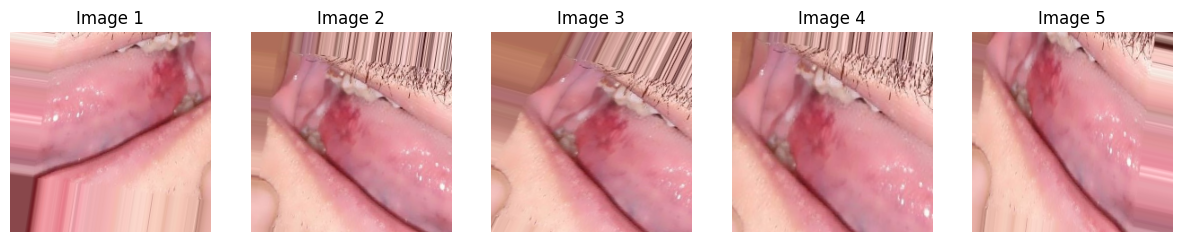

In [8]:
import matplotlib.pyplot as plt

# Function to display 5 images
def display_images(images, num_images=5):
    # Set up the plot with a grid for 5 images
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])  # Display the image
        plt.axis('off')  # Turn off the axis
        plt.title(f"Image {i+1}")  # Title for each image
    
    plt.show()

# Assuming augmented_cancer_images is your list of images
display_images(augmented_cancer_images, num_images=5)


# **Kaggle-Histopathological Dataset**

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --------------------------- #
# Define Image Preprocessing Function
# --------------------------- #
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(img_height, img_width))  # Resize image
    image_array = img_to_array(image)  # Convert image to array
    image_array = image_array / 255.0  # Normalize image values between 0 and 1
    return image_array

# --------------------------- #
# Define Paths for Dataset
# --------------------------- #
oscc_path = os.path.join(mendeley_data_path, 'OSCC/')  # Path to OSCC images
normal_path = os.path.join(mendeley_data_path, 'Normal/')  # Path to Normal images

# --------------------------- #
# Initialize Lists to Store Images
# --------------------------- #
oscc_images = []
normal_images = []

# --------------------------- #
# Load and Preprocess OSCC Images
# --------------------------- #
for fname in os.listdir(oscc_path):
    if fname.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
        img_path = os.path.join(oscc_path, fname)
        oscc_images.append(preprocess_image(img_path))

# --------------------------- #
# Load and Preprocess Normal Images
# --------------------------- #
for fname in os.listdir(normal_path):
    if fname.endswith(('.jpg', '.jpeg', '.png')):  # Check for image file types
        img_path = os.path.join(normal_path, fname)
        normal_images.append(preprocess_image(img_path))

# --------------------------- #
# Convert Lists to NumPy Arrays
# --------------------------- #
oscc_images = np.array(oscc_images)
normal_images = np.array(normal_images)

# --------------------------- #
# Print Original Dataset Size
# --------------------------- #
print(f"Original OSCC images: {len(oscc_images)}")
print(f"Original Normal images: {len(normal_images)}")

# --------------------------- #
# Data Augmentation Setup
# --------------------------- #
datagen = ImageDataGenerator(
    rotation_range=20,       # Random rotation between -20 and +20 degrees
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1, # Random vertical shift
    shear_range=0.1,        # Shear transformations
    zoom_range=0.1,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'     # Strategy for filling in newly created pixels
)

# --------------------------- #
# Define Augmentation Factor
# --------------------------- #
augment_factor = 5  # You can adjust this number as needed

# --------------------------- #
# Augment OSCC Images
# --------------------------- #
augmented_oscc = []
for img in oscc_images:
    img = img.reshape((1,) + img.shape)  # Reshape for augmentation (1, h, w, c)
    aug_iter = datagen.flow(img, batch_size=1)
    augmented_oscc.extend([next(aug_iter)[0] for _ in range(augment_factor)])  # Generate N augmented versions

# --------------------------- #
# Augment Normal Images
# --------------------------- #
augmented_normal = []
for img in normal_images:
    img = img.reshape((1,) + img.shape)  # Reshape for augmentation (1, h, w, c)
    aug_iter = datagen.flow(img, batch_size=1)
    augmented_normal.extend([next(aug_iter)[0] for _ in range(augment_factor)])  # Generate N augmented versions

# --------------------------- #
# Combine Original + Augmented Data
# --------------------------- #
final_oscc = np.concatenate([oscc_images, np.array(augmented_oscc)])
final_normal = np.concatenate([normal_images, np.array(augmented_normal)])

# --------------------------- #
# Print Final Dataset Size
# --------------------------- #
print(f"Final OSCC images (original + augmented): {len(final_oscc)}")
print(f"Final Normal images (original + augmented): {len(final_normal)}")

# --------------------------- #
# Prepare Labels
# --------------------------- #
labels = np.array([1] * len(final_oscc) + [0] * len(final_normal))  # 1=OSCC, 0=Normal
dataset = np.concatenate([final_oscc, final_normal])  # Combine all images

# --------------------------- #
# Verify Shapes
# --------------------------- #
print(f"Dataset shape: {dataset.shape}")  # Should be (num_samples, height, width, channels)
print(f"Labels shape: {labels.shape}")    # Should be (num_samples,)

Original OSCC images: 95
Original Normal images: 31
Final OSCC images (original + augmented): 570
Final Normal images (original + augmented): 186
Dataset shape: (756, 224, 224, 3)
Labels shape: (756,)


# **Kaggle-Histopathological Data view**

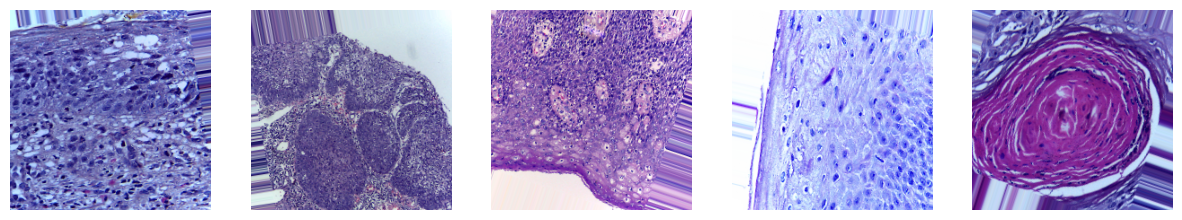

In [10]:
import matplotlib.pyplot as plt
import random

# --------------------------- #
# Display Some Images from the Dataset
# --------------------------- #

# Define how many images to display
num_images_to_show = 5

# Combine OSCC and Normal images into one list for random selection
combined_images = np.concatenate([final_oscc, final_normal])

# Randomly select some images from the combined dataset
selected_images = random.sample(list(combined_images), num_images_to_show)

# Plotting the selected images
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 15))

# Loop through selected images and display them
for i, img in enumerate(selected_images):
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis

# Add title to the figure
# fig.suptitle('Histopathological Samples', fontsize=16)

# Adjust the distance between the title and the images (reduce the top margin)
plt.subplots_adjust(top=0.8)  # This reduces the space between the title and images

# Show the images
plt.show()


# **Create Hybrid Dataset [Clinical + Histopathological]**

In [11]:


# -----------------------------
# Check the number of images in each list
# -----------------------------
print(f"OSCC images: {len(final_oscc)} images")
print(f"Normal images: {len(final_normal)} images")

print(f"Cancer images: {len(augmented_cancer_images)} images")
print(f"Non-cancer images: {len(augmented_non_cancer_images)} images")

# -----------------------------
# Validate that each list is not empty
# -----------------------------
if len(oscc_images) == 0:
    print("Error: No images loaded from OSCC directory.")
if len(normal_images) == 0:
    print("Error: No images loaded from Normal directory.")

# -----------------------------
# Create the dataset
# -----------------------------
hybrid_data = []

# -----------------------------
# Define helper function to add non-empty image lists
# -----------------------------
def add_images_to_hybrid_data(image_list):
    if len(image_list) > 0:
        hybrid_data.extend(image_list)
    else:
        print(f"Warning: Empty image list for label, skipping.")

# -----------------------------
# Add images to the dataset with appropriate labels
# -----------------------------
add_images_to_hybrid_data(augmented_oscc)  # Using 1 for OSCC (cancer)
add_images_to_hybrid_data(augmented_normal)  # Using 0 for Normal (non-cancer

add_images_to_hybrid_data(augmented_cancer_images)  
add_images_to_hybrid_data(augmented_non_cancer_images)


# -----------------------------
# Convert to numpy arrays
# -----------------------------
# dataset = np.array(dataset)
# labels = np.array(labels)

# -----------------------------
# Final check of the dataset
# -----------------------------
print(f"Total images in hybrid dataset: {len(hybrid_data)}")

OSCC images: 570 images
Normal images: 186 images
Cancer images: 2500 images
Non-cancer images: 1250 images
Total images in hybrid dataset: 4380


# **Train Test Split**

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split

# -----------------------------
# Check the number of images in each list
# -----------------------------
print(f"OSCC images: {len(augmented_oscc)} images")
print(f"Normal images: {len(augmented_normal)} images")
print(f"Cancer images: {len(augmented_cancer_images)} images")
print(f"Non-cancer images: {len(augmented_non_cancer_images)} images")

# -----------------------------
# Validate that each list is not empty
# -----------------------------
if len(augmented_oscc) == 0:
    print("Error: No images loaded from OSCC directory.")
if len(augmented_normal) == 0:
    print("Error: No images loaded from Normal directory.")
if len(augmented_cancer_images) == 0:
    print("Error: No images loaded from Cancer directory.")
if len(augmented_non_cancer_images) == 0:
    print("Error: No images loaded from Non-Cancer directory.")

# -----------------------------
# Create the dataset
# -----------------------------
hybrid_data = []

# -----------------------------
# Define helper function to add non-empty image lists
# -----------------------------
def add_images_to_hybrid_data(image_list):
    if len(image_list) > 0:
        hybrid_data.extend(image_list)
    else:
        print(f"Warning: Empty image list, skipping.")

# -----------------------------
# Add images to the dataset with appropriate labels
# -----------------------------
add_images_to_hybrid_data(augmented_oscc)  # Using 1 for OSCC (cancer)
add_images_to_hybrid_data(augmented_normal)  # Using 0 for Normal (non-cancer)
add_images_to_hybrid_data(augmented_cancer_images)  # Cancer images
add_images_to_hybrid_data(augmented_non_cancer_images)  # Non-Cancer images

# -----------------------------
# Check hybrid data size
# -----------------------------
print(f"Total images in hybrid dataset: {len(hybrid_data)}")

# -------------------- Step 1: Prepare Labels --------------------
# Ensure labels correspond to the correct number of images
labels = np.array([1] * len(augmented_oscc) + [0] * len(augmented_normal) + [1] * len(augmented_cancer_images) + [0] * len(augmented_non_cancer_images))

# Double-check the length of the labels
print(f"Labels length: {len(labels)}")

# -------------------- Step 2: Combine Images into Dataset --------------------
# Combine OSCC, Normal, Cancer, and Non-Cancer images
dataset = np.concatenate([augmented_oscc, augmented_normal, augmented_cancer_images, augmented_non_cancer_images])

# Double-check the dataset size
print(f"Dataset size after concatenation: {len(dataset)}")

# -----------------------------
# Check if there are any None values in the dataset
# -----------------------------
print(f"Any None values in dataset: {np.any([img is None for img in dataset])}")

# -----------------------------
# Check dataset and label shapes before splitting
# -----------------------------
print(f"Dataset shape before splitting: {dataset.shape}")
print(f"Labels shape before splitting: {labels.shape}")
print(f"First few labels: {labels[:10]}")

# -------------------- Step 3: Split Dataset --------------------
# Split into training (80%) and testing (20%) sets with stratification (balanced classes)
X_train, X_test, y_train, y_test = train_test_split(
    dataset, 
    labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=labels  # Ensures equal class distribution in train/test
)

# -------------------- Step 4: Display Dataset Size --------------------
print(f"Training data: {len(X_train)} images")  
print(f"Testing data: {len(X_test)} images")  
print(f"Class distribution in Training: Normal (0) = {np.sum(y_train == 0)}, OSCC (1) = {np.sum(y_train == 1)}")  
print(f"Class distribution in Testing: Normal (0) = {np.sum(y_test == 0)}, OSCC (1) = {np.sum(y_test == 1)}")


OSCC images: 475 images
Normal images: 155 images
Cancer images: 2500 images
Non-cancer images: 1250 images
Total images in hybrid dataset: 4380
Labels length: 4380
Dataset size after concatenation: 4380
Any None values in dataset: False
Dataset shape before splitting: (4380, 224, 224, 3)
Labels shape before splitting: (4380,)
First few labels: [1 1 1 1 1 1 1 1 1 1]
Training data: 3504 images
Testing data: 876 images
Class distribution in Training: Normal (0) = 1124, OSCC (1) = 2380
Class distribution in Testing: Normal (0) = 281, OSCC (1) = 595


# **CNN Model**

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# Define CNN Model Architecture
# -----------------------------
def create_cnn_model(input_shape):
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # 2nd Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # 3rd Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the features for the fully connected layers
    model.add(Flatten())

    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # To prevent overfitting

    # Output layer (Binary classification)
    model.add(Dense(1, activation='sigmoid'))

    return model

# -----------------------------
# Model Compilation and Training
# -----------------------------
input_shape = (224, 224, 3)  # Shape of each image in the dataset
model = create_cnn_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping]
)

# -----------------------------
# Evaluate the Model
# -----------------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")




Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
I0000 00:00:1769087005.601064      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1769087013.477707     100 service.cc:148] XLA service 0x795de00058a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769087013.478618     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769087013.791851     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/219 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6118 - loss: 1.1328

I0000 00:00:1769087016.967435     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.6779 - loss: 0.6964 - val_accuracy: 0.7820 - val_loss: 0.5309
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7667 - loss: 0.5291 - val_accuracy: 0.7694 - val_loss: 0.5024
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7810 - loss: 0.4950 - val_accuracy: 0.7683 - val_loss: 0.5328
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7866 - loss: 0.4926 - val_accuracy: 0.7934 - val_loss: 0.4683
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8155 - loss: 0.4238 - val_accuracy: 0.8116 - val_loss: 0.4594
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8408 - loss: 0.3779 - val_accuracy: 0.8139 - val_loss: 0.4702
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8726 - loss: 0.2912 - val_accuracy: 0.8139 - val_loss: 0.4787
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9005 - loss: 0.2582 - val_accuracy: 0.80

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# -----------------------------
# Print Highest Accuracies
# -----------------------------
highest_train_acc = max(history.history['accuracy'])
highest_val_acc = max(history.history['val_accuracy'])
print(f"Highest Training Accuracy: {highest_train_acc:.4f}")
print(f"Highest Validation Accuracy: {highest_val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Highest Training Accuracy: 0.9272
Highest Validation Accuracy: 0.8276
Test Accuracy: 0.8116


# **Confusion Matrix**

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


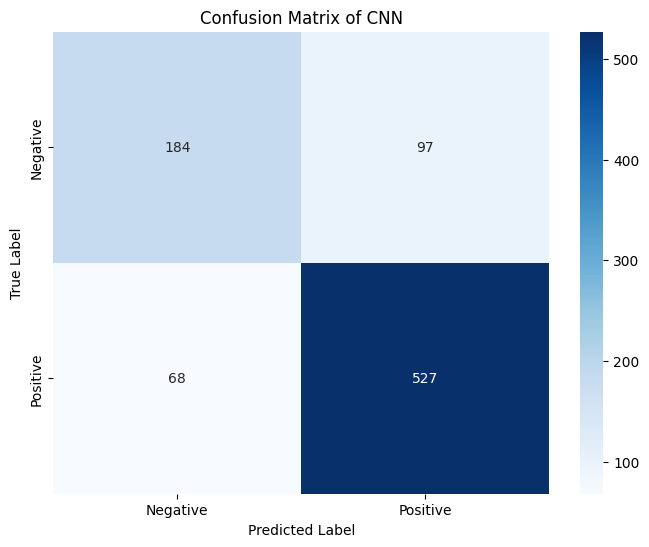

In [15]:

# -----------------------------
# Confusion Matrix
# -----------------------------
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of CNN')
plt.show()


# **Accuracy vs Validation Accuracy**

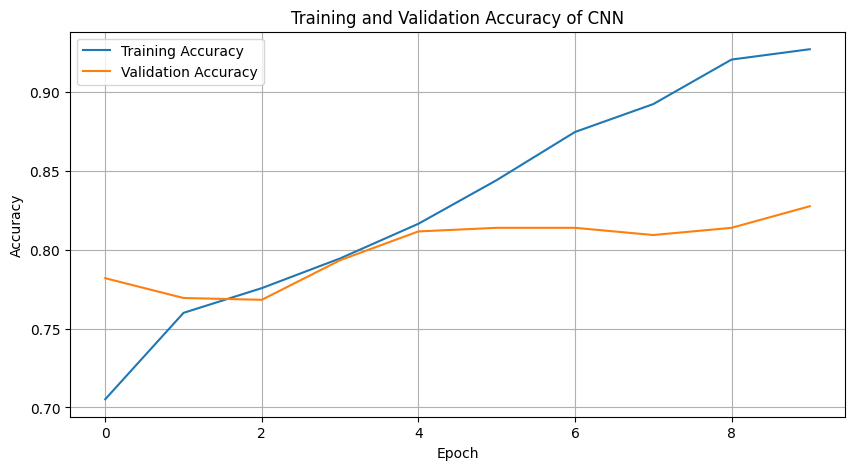

In [16]:

# -----------------------------
# Accuracy vs Validation Accuracy Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# **Loss vs Validation Loss**

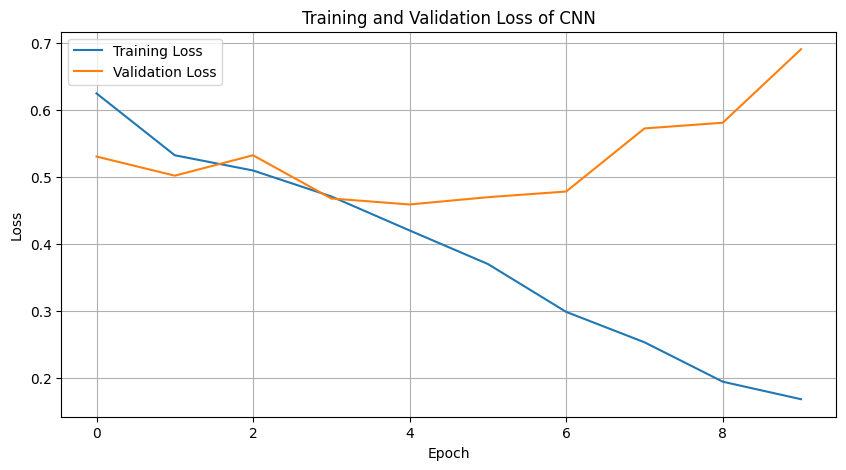

In [17]:

# -----------------------------
# Loss vs Validation Loss Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# **ROC Curve**

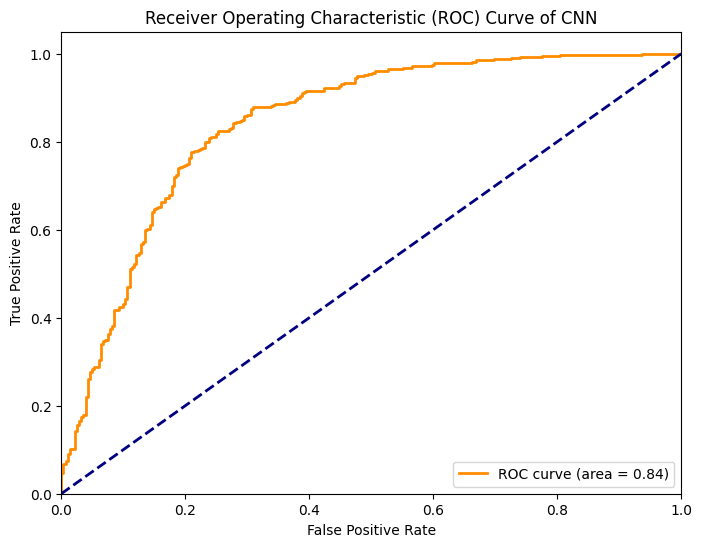

In [18]:

# -----------------------------
# ROC Curve
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of CNN')
plt.legend(loc="lower right")
plt.show()

# **InceptionV3 Model**

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# Load Pre-trained InceptionV3 Model
# -----------------------------
def create_inceptionv3_model(input_shape):
    # Load InceptionV3 with pre-trained ImageNet weights
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base layers so that the weights aren't updated during training
    base_model.trainable = False

    # Create the custom head of the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions

    # Add a fully connected layer with L2 regularization (penalty)
    x = Dense(128, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01))(x)  # L2 penalty
    x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting

    # Output layer (Binary classification: OSCC vs Normal)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# -----------------------------
# Model Compilation and Training
# -----------------------------
input_shape = (224, 224, 3)  # Shape of each image
model = create_inceptionv3_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=70, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping]
)

# -----------------------------
# Evaluate the Model
# -----------------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")




87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 231ms/step - accuracy: 0.6890 - loss: 2.9651 - val_accuracy: 0.8345 - val_loss: 2.4215
Epoch 2/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8299 - loss: 2.3667 - val_accuracy: 0.8619 - val_loss: 2.0769
Epoch 3/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8390 - loss: 2.0787 - val_accuracy: 0.8676 - val_loss: 1.8181
Epoch 4/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8612 - loss: 1.8013 - val_accuracy: 0.8858 - val_loss: 1.6138
Epoch 5/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8727 - loss: 1.6149 - val_accuracy: 0.8699 - val_loss: 1.4681
Epoch 6/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8954 - loss: 1.4327 - val_accuracy: 0.8927 - val_loss: 1.3510
Epoch 7/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8824 - loss: 1.3298 - val_accuracy: 0.8938 - val_loss: 1.2175
Epoch 8/70
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 5

In [20]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# -----------------------------
# Print Highest Accuracies
# -----------------------------
highest_train_acc = max(history.history['accuracy'])
highest_val_acc = max(history.history['val_accuracy'])
print(f"Highest Training Accuracy: {highest_train_acc:.4f}")
print(f"Highest Validation Accuracy: {highest_val_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Highest Training Accuracy: 0.9826
Highest Validation Accuracy: 0.9429
Final Test Accuracy: 0.9395


# **Confusion Matrix**

28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step


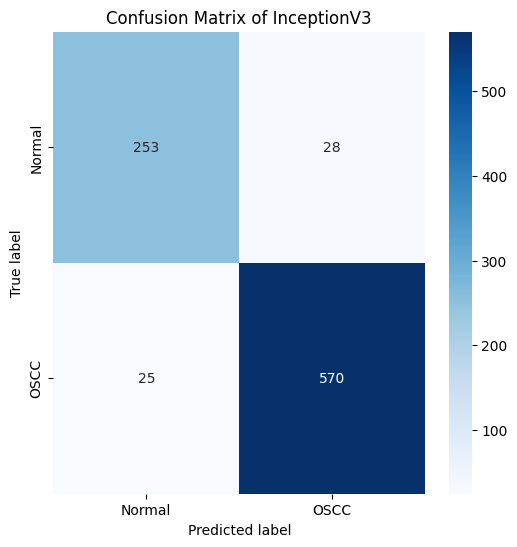

In [21]:

# -----------------------------
# Confusion Matrix
# -----------------------------
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'OSCC'], 
            yticklabels=['Normal', 'OSCC'])
plt.title('Confusion Matrix of InceptionV3')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# **Accuracy vs Validation Accuracy**

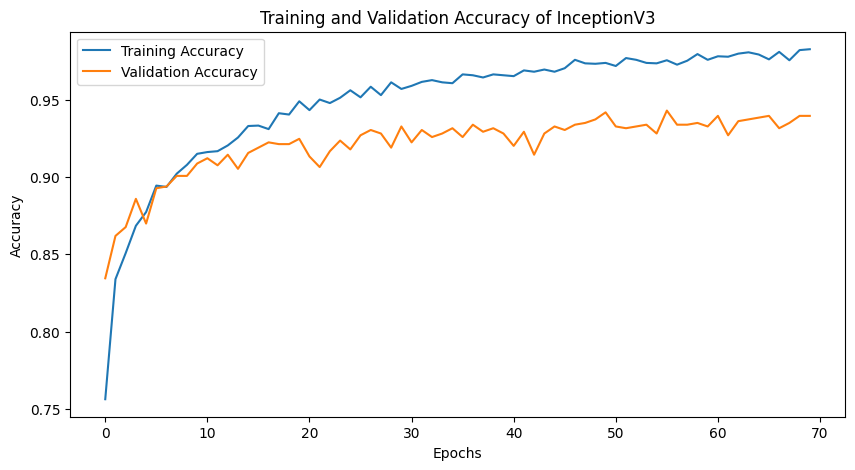

In [22]:

# -----------------------------
# Accuracy vs Validation Accuracy Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy of InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# **Loss vs Validation Loss**

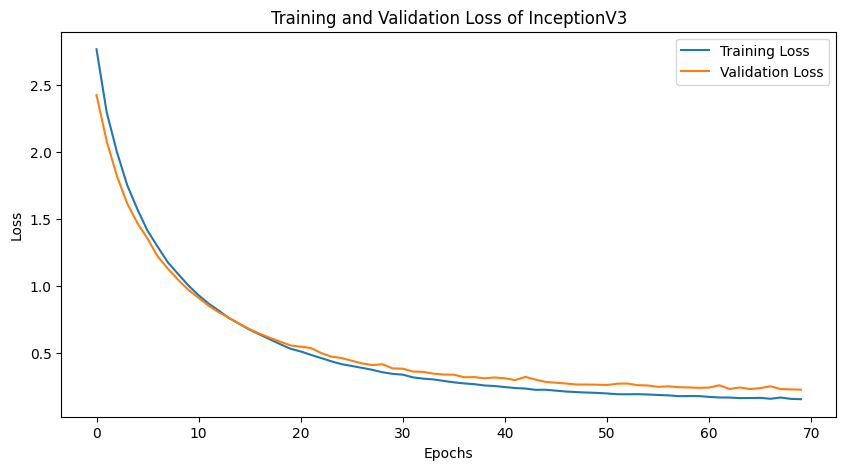

In [23]:

# -----------------------------
# Loss vs Validation Loss Plot
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **ROC Curve**

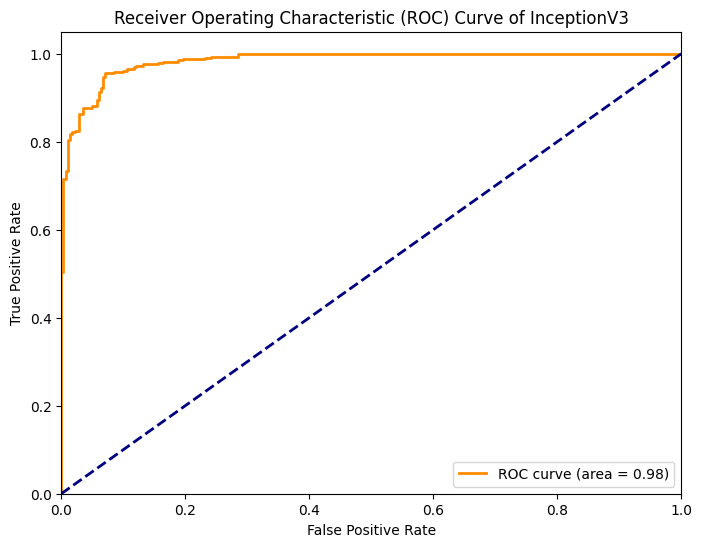

In [24]:

# -----------------------------
# ROC Curve
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of InceptionV3')
plt.legend(loc="lower right")
plt.show()

# **Vision Transformer AI Model**

In [25]:
# ----------------------------
# Load Pre-trained ViT Model and Feature Extractor
# ----------------------------
model_name = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2)  # 2 labels: cancer and non-cancer
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# ----------------------------
# Set Device (GPU or CPU)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [26]:
# ----------------------------
# Function to preprocess an image for Vision Transformer (ViT)
# ----------------------------
def preprocess_image_vit(image_array):
    # Preprocess the image for ViT, disabling rescaling
    encoding = feature_extractor(images=image_array, return_tensors="pt", do_rescale=False)
    return encoding

# ... (rest of the code) ...

class CustomDataset(Dataset):
    def __init__(self, image_arrays, labels, feature_extractor): # Change image_paths to image_arrays
        self.image_arrays = image_arrays # Change image_paths to image_arrays
        self.labels = labels
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_arrays) # Change image_paths to image_arrays

    def __getitem__(self, idx):
        image_array = self.image_arrays[idx] # Change image_path to image_array and image_paths to image_arrays
        label = self.labels[idx]
        # Preprocess the image for ViT
        encoding = preprocess_image_vit(image_array) # Pass image_array instead of image_path
        return {**encoding, 'label': torch.tensor(label)}

# ... (rest of the code) ...

# Split dataset into training and testing sets
train_arrays, test_arrays, train_labels, test_labels = train_test_split( # Change train_paths/test_paths to train_arrays/test_arrays
    hybrid_data, labels, test_size=0.2, random_state=42
)

# Create DataLoader for training dataset
train_dataset = CustomDataset(train_arrays, train_labels, feature_extractor) # Change train_paths to train_arrays
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Create DataLoader for testing dataset
test_dataset = CustomDataset(test_arrays, test_labels, feature_extractor) # Change test_paths to test_arrays
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [27]:
import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------
# Optimizer and Loss Function
# ----------------------------
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# ----------------------------
# Initialize variables to track highest accuracies
# ----------------------------
best_val_accuracy = 0
best_test_accuracy = 0
best_preds = []
best_labels = []

# ----------------------------
# Training Function
# ----------------------------
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)

        outputs = model(pixel_values=pixel_values.squeeze(1), labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate(model, test_loader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            outputs = model(pixel_values=pixel_values.squeeze(1), labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            predictions = torch.argmax(F.softmax(logits, dim=1), dim=1)

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy, all_preds, all_labels


import matplotlib.pyplot as plt

# Initialize lists to store training and validation metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training Loop (Updated to track accuracy and loss)
for epoch in range(10):  # Update epochs as needed
    train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    val_accuracy = train_accuracy  # Placeholder for actual validation logic
    val_losses.append(train_loss)  # Assuming validation loss is the same as training loss in this case
    val_accuracies.append(val_accuracy)

    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy

    test_loss, test_accuracy, preds, labels = evaluate(model, test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_preds = preds
        best_labels = labels

# ----------------------------
# Final Evaluation Metrics
# ----------------------------
print(f"\nHighest Validation Accuracy Achieved: {best_val_accuracy * 100:.2f}%")
print(f"Highest Test Accuracy Achieved: {best_test_accuracy * 100:.2f}%\n")


100%|██████████| 438/438 [01:29<00:00,  4.92it/s]


Epoch 1 - Loss: 0.2108, Accuracy: 0.9195


100%|██████████| 110/110 [00:09<00:00, 11.60it/s]


Test Loss: 0.0948, Test Accuracy: 0.9646


100%|██████████| 438/438 [01:28<00:00,  4.94it/s]


Epoch 2 - Loss: 0.0552, Accuracy: 0.9829


100%|██████████| 110/110 [00:09<00:00, 11.65it/s]


Test Loss: 0.0276, Test Accuracy: 0.9886


100%|██████████| 438/438 [01:28<00:00,  4.94it/s]


Epoch 3 - Loss: 0.0291, Accuracy: 0.9900


100%|██████████| 110/110 [00:09<00:00, 11.68it/s]


Test Loss: 0.0936, Test Accuracy: 0.9589


100%|██████████| 438/438 [01:28<00:00,  4.95it/s]


Epoch 4 - Loss: 0.0250, Accuracy: 0.9920


100%|██████████| 110/110 [00:09<00:00, 11.71it/s]


Test Loss: 0.0322, Test Accuracy: 0.9886


100%|██████████| 438/438 [01:28<00:00,  4.95it/s]


Epoch 5 - Loss: 0.0105, Accuracy: 0.9977


100%|██████████| 110/110 [00:09<00:00, 12.03it/s]


Test Loss: 0.0335, Test Accuracy: 0.9909


100%|██████████| 438/438 [01:27<00:00,  4.99it/s]


Epoch 6 - Loss: 0.0017, Accuracy: 0.9997


100%|██████████| 110/110 [00:09<00:00, 11.93it/s]


Test Loss: 0.0261, Test Accuracy: 0.9932


100%|██████████| 438/438 [01:28<00:00,  4.95it/s]


Epoch 7 - Loss: 0.0008, Accuracy: 1.0000


100%|██████████| 110/110 [00:09<00:00, 11.74it/s]


Test Loss: 0.0294, Test Accuracy: 0.9920


100%|██████████| 438/438 [01:28<00:00,  4.93it/s]


Epoch 8 - Loss: 0.0006, Accuracy: 1.0000


100%|██████████| 110/110 [00:09<00:00, 11.63it/s]


Test Loss: 0.0311, Test Accuracy: 0.9920


100%|██████████| 438/438 [01:29<00:00,  4.91it/s]


Epoch 9 - Loss: 0.0004, Accuracy: 1.0000


100%|██████████| 110/110 [00:09<00:00, 11.52it/s]


Test Loss: 0.0327, Test Accuracy: 0.9920


100%|██████████| 438/438 [01:29<00:00,  4.92it/s]


Epoch 10 - Loss: 0.0003, Accuracy: 1.0000


100%|██████████| 110/110 [00:09<00:00, 11.50it/s]

Test Loss: 0.0344, Test Accuracy: 0.9920

Highest Validation Accuracy Achieved: 100.00%
Highest Test Accuracy Achieved: 99.32%



In [28]:
print(train_accuracies)
print(val_accuracies)

[0.9195205479452054, 0.9828767123287672, 0.9900114155251142, 0.9920091324200914, 0.997716894977169, 0.9997146118721462, 1.0, 1.0, 1.0, 1.0]
[0.9195205479452054, 0.9828767123287672, 0.9900114155251142, 0.9920091324200914, 0.997716894977169, 0.9997146118721462, 1.0, 1.0, 1.0, 1.0]


In [29]:
# ----------------------------
# Print Highest Accuracies
# ----------------------------
print(f"\nHighest Validation Accuracy Achieved: {best_val_accuracy * 100:.2f}%")
print(f"Highest Test Accuracy Achieved: {best_test_accuracy * 100:.2f}%\n")




Highest Validation Accuracy Achieved: 100.00%
Highest Test Accuracy Achieved: 99.32%



# **Confusion Matrix**

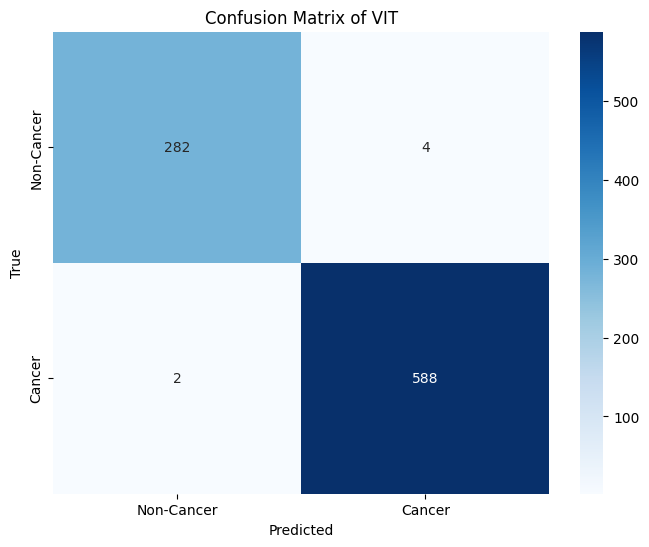

In [30]:
# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Cancer', 'Cancer'], 
            yticklabels=['Non-Cancer', 'Cancer'])
plt.title('Confusion Matrix of VIT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# **Accuracy vs Validation Accuracy**

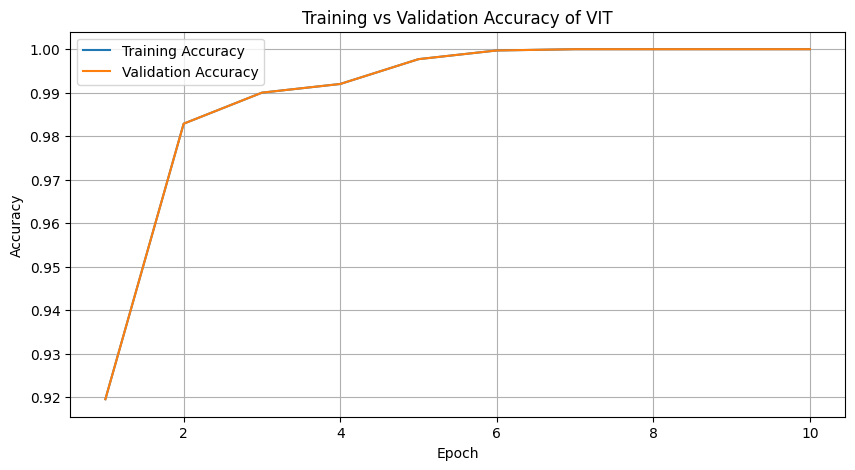

In [31]:

# ----------------------------
# Accuracy vs Validation Accuracy Plot
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy of VIT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# **Loss vs Validation Loss**

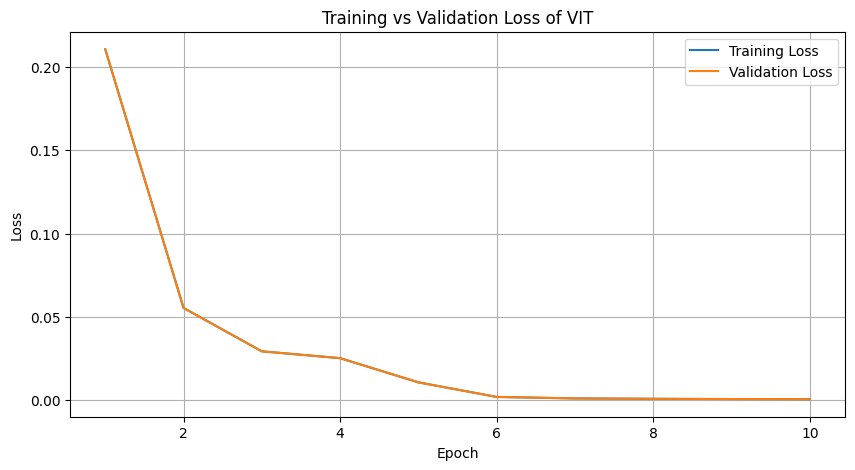

In [32]:

# ----------------------------
# Loss vs Validation Loss Plot
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss of VIT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



# **ROC Curve**

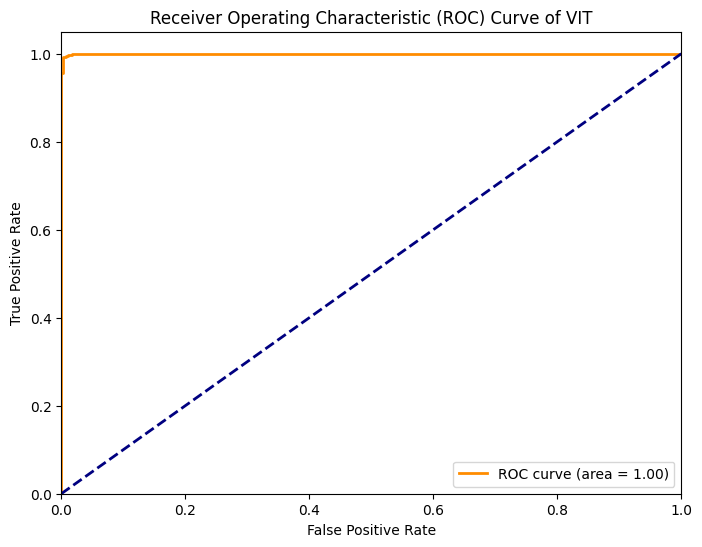

In [33]:
# ----------------------------
# ROC Curve
# ----------------------------
from sklearn.metrics import roc_curve, auc

# First we need to get the probability scores
model.eval()
all_probs = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(pixel_values=pixel_values.squeeze(1))
        probs = F.softmax(outputs.logits, dim=1)
        
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
        all_true.extend(labels.cpu().numpy())

fpr, tpr, thresholds = roc_curve(all_true, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of VIT')
plt.legend(loc="lower right")
plt.show()



# **Ensamble 3 models**

In [34]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

# ---------------------------------------------------------
# PREPROCESSING FUNCTIONS
# ---------------------------------------------------------
def preprocess_for_keras(image_path, target_size=(224, 224)):
    """Preprocesses image for CNN and InceptionV3 (Keras)."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img_batch = np.expand_dims(img, axis=0)
    return img_batch

def preprocess_for_vit(image_path, feature_extractor, device):
    """Preprocesses image for Vision Transformer (PyTorch)."""
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt") 
    return inputs.to(device)

# ---------------------------------------------------------
# ENSEMBLE PREDICTION FUNCTION
# ---------------------------------------------------------
def ensemble_predict(image_path, cnn_model, inception_model, vit_model, feature_extractor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Processing: {image_path}")

    # 1. CNN Prediction
    input_keras = preprocess_for_keras(image_path)
    cnn_pred = cnn_model.predict(input_keras, verbose=0)[0][0]

    # 2. Inception Prediction
    inception_pred = inception_model.predict(input_keras, verbose=0)[0][0]

    # 3. ViT Prediction
    vit_inputs = preprocess_for_vit(image_path, feature_extractor, device)
    vit_model.to(device)
    vit_model.eval()
    with torch.no_grad():
        outputs = vit_model(**vit_inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        # Assuming Index 1 is Cancer (Check your label mapping)
        vit_pred = probs[0][1].item() 

    # 4. Aggregation
    avg_probability = (cnn_pred + inception_pred + vit_pred) / 3.0
    final_class = "Cancer" if avg_probability > 0.5 else "Normal"
    
    return {
        "CNN_Probability": float(cnn_pred),
        "Inception_Probability": float(inception_pred),
        "ViT_Probability": float(vit_pred),
        "Ensemble_Probability": float(avg_probability),
        "Final_Prediction": final_class
    }

In [44]:
# ==========================================
# STEP 1: LOAD/DEFINE MODELS WITH UNIQUE NAMES
# ==========================================

# 1. Load CNN
# (Make sure to run your CNN definition code first if not already in memory)
cnn_model_final = create_cnn_model((224, 224, 3))
# Load weights if you saved them, e.g., cnn_model_final.load_weights('cnn_weights.h5')
# If you just trained it, assign the trained variable:
# cnn_model_final = model  (ONLY if 'model' is currently the CNN)

# 2. Load Inception
# (Make sure to run your Inception definition code)
inception_model_final = create_inceptionv3_model((224, 224, 3))
# Load weights if saved: inception_model_final.load_weights('inception_weights.h5')

# 3. Load ViT
# (Make sure to run your ViT definition code)
vit_model_final = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
vit_model_final.to(device)


# ==========================================
# STEP 2: RUN ENSEMBLE WITH CORRECT VARIABLES
# ==========================================

# Define the path to your image
test_image_path = "/kaggle/input/kaggle-clinical/CANCER/027.jpeg"  # <--- REPLACE THIS with your actual image path

# Call the function passing the UNIQUE variable names
result = ensemble_predict(
    image_path=test_image_path,
    cnn_model=cnn_model_final,          # Pass the Keras CNN here
    inception_model=inception_model_final, # Pass the Keras Inception here
    vit_model=vit_model_final,          # Pass the PyTorch ViT here
    feature_extractor=feature_extractor
)

# ==========================================
# STEP 3: VIEW RESULTS
# ==========================================
print("\n--- Ensemble Results ---")
print(f"CNN Prediction:       {result['CNN_Probability']:.4f}")
print(f"Inception Prediction: {result['Inception_Probability']:.4f}")
print(f"ViT Prediction:       {result['ViT_Probability']:.4f}")
print("-" * 30)
print(f"Combined Probability: {result['Ensemble_Probability']:.4f}")
print(f"FINAL DIAGNOSIS:      {result['Final_Prediction']}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing: /kaggle/input/kaggle-clinical/CANCER/027.jpeg

--- Ensemble Results ---
CNN Prediction:       0.5063
Inception Prediction: 0.8416
ViT Prediction:       0.4883
------------------------------
Combined Probability: 0.6121
FINAL DIAGNOSIS:      Cancer


# **Save the model Locally**

In [45]:
import os
import shutil

# 1. Create a directory to hold all models
save_dir = "ensemble_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

# ---------------------------------------------------------
# SAVE KERAS MODELS (CNN & INCEPTION)
# ---------------------------------------------------------
print("Saving Keras models...")

# Save CNN
cnn_save_path = os.path.join(save_dir, "cnn_model.h5")
cnn_model_final.save(cnn_save_path)
print(f"✅ CNN saved to: {cnn_save_path}")

# Save InceptionV3
inception_save_path = os.path.join(save_dir, "inception_model.h5")
inception_model_final.save(inception_save_path)
print(f"✅ InceptionV3 saved to: {inception_save_path}")

# ---------------------------------------------------------
# SAVE PYTORCH MODEL (ViT)
# ---------------------------------------------------------
print("Saving ViT model...")

# Create a subfolder specifically for ViT files
vit_save_dir = os.path.join(save_dir, "vit_model")

# Save the model weights and config
vit_model_final.save_pretrained(vit_save_dir)

# CRITICAL: Save the feature extractor (preprocessor) too
# This ensures you don't have to manually guess normalization values later
feature_extractor.save_pretrained(vit_save_dir)

print(f"✅ ViT model and preprocessor saved to: {vit_save_dir}")

# ---------------------------------------------------------
# ZIP EVERYTHING (For Easy Download)
# ---------------------------------------------------------
print("Zipping files for download...")
shutil.make_archive("ensemble_models_archive", 'zip', save_dir)
print(f"🎉 Process Complete! You can now download 'ensemble_models_archive.zip'")

Created directory: ensemble_models
Saving Keras models...
✅ CNN saved to: ensemble_models/cnn_model.h5
✅ InceptionV3 saved to: ensemble_models/inception_model.h5
Saving ViT model...
✅ ViT model and preprocessor saved to: ensemble_models/vit_model
Zipping files for download...
🎉 Process Complete! You can now download 'ensemble_models_archive.zip'


# **Test the Model**

In [47]:
import os
import cv2
import numpy as np
import tensorflow as tf
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor

# ==========================================
# 1. SETUP PATHS
# ==========================================
BASE_DIR = "ensemble_models"  # Folder containing your models
TEST_IMAGE_PATH = "/kaggle/input/kaggle-clinical/NON CANCER/004.jpeg" # Replace with your image

# ==========================================
# 2. LOADING FUNCTIONS
# ==========================================
def load_models():
    print("⏳ Loading Keras models (CNN & Inception)...")
    try:
        cnn = tf.keras.models.load_model(os.path.join(BASE_DIR, "cnn_model.h5"))
        inception = tf.keras.models.load_model(os.path.join(BASE_DIR, "inception_model.h5"))
        print("✅ Keras models loaded.")
    except Exception as e:
        print(f"❌ Error loading Keras models: {e}")
        exit()

    print("⏳ Loading PyTorch model (ViT)...")
    try:
        vit_path = os.path.join(BASE_DIR, "vit_model")
        vit_model = ViTForImageClassification.from_pretrained(vit_path)
        vit_processor = ViTImageProcessor.from_pretrained(vit_path)
        vit_model.eval() # Set to evaluation mode
        print("✅ ViT model loaded.")
    except Exception as e:
        print(f"❌ Error loading ViT model: {e}")
        exit()
        
    return cnn, inception, vit_model, vit_processor

# ==========================================
# 3. PREPROCESSING FUNCTIONS
# ==========================================
def preprocess_keras(image_path):
    """Read image -> Resize (224,224) -> Normalize -> Expand Dims"""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=0)

def preprocess_vit(image_path, processor):
    """Load image -> Use HuggingFace processor"""
    img = Image.open(image_path).convert("RGB")
    return processor(images=img, return_tensors="pt")

# ==========================================
# 4. PREDICTION LOGIC
# ==========================================
def run_ensemble(image_path, cnn, inception, vit, vit_processor):
    print(f"\n🔍 Analyzing: {image_path}...")

    # A. Keras Predictions (CNN & Inception)
    input_keras = preprocess_keras(image_path)
    
    # verbose=0 hides the progress bar
    pred_cnn = cnn.predict(input_keras, verbose=0)[0][0]
    pred_inception = inception.predict(input_keras, verbose=0)[0][0]

    # B. PyTorch Prediction (ViT)
    input_vit = preprocess_vit(image_path, vit_processor)
    
    with torch.no_grad():
        outputs = vit(**input_vit)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        
        # Assuming index 1 is the positive class (Cancer)
        # Verify this against your training labels! 
        # If your training was [Healthy, Cancer], use index 1.
        pred_vit = probs[0][1].item() 

    # C. Average (Ensemble)
    avg_conf = (pred_cnn + pred_inception + pred_vit) / 3.0
    
    return pred_cnn, pred_inception, pred_vit, avg_conf

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # Check if image exists
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f"❌ Error: Please put a test image at '{TEST_IMAGE_PATH}'")
        exit()

    # Load
    cnn_model, inception_model, vit_model, vit_proc = load_models()

    # Predict
    p_cnn, p_inc, p_vit, p_avg = run_ensemble(
        TEST_IMAGE_PATH, cnn_model, inception_model, vit_model, vit_proc
    )

    # Result
    final_label = "⚠️ CANCER POSITIVE" if p_avg > 0.5 else "✅ CANCER NEGATIVE"
    
    print("\n" + "="*40)
    print("ENSEMBLE DIAGNOSIS REPORT")
    print("="*40)
    print(f"CNN Model       : {p_cnn*100:.2f}%")
    print(f"Inception Model : {p_inc*100:.2f}%")
    print(f"ViT Model       : {p_vit*100:.2f}%")
    print("-" * 40)
    print(f"Combined Score  : {p_avg*100:.2f}%")
    print(f"FINAL RESULT    : {final_label}")
    print("="*40 + "\n")

⏳ Loading Keras models (CNN & Inception)...
✅ Keras models loaded.
⏳ Loading PyTorch model (ViT)...
✅ ViT model loaded.

🔍 Analyzing: /kaggle/input/kaggle-clinical/NON CANCER/004.jpeg...

ENSEMBLE DIAGNOSIS REPORT
CNN Model       : 51.00%
Inception Model : 46.41%
ViT Model       : 47.43%
----------------------------------------
Combined Score  : 48.28%
FINAL RESULT    : ✅ CANCER NEGATIVE



# **Upload the model in Hugging face**

In [ ]:
from huggingface_hub import HfApi, login

# ==========================================
# 1. CONFIGURATION
# ==========================================
# PASTE YOUR WRITE TOKEN HERE
hf_token = "" 

# Choose a name for your new repository
# Example: "ankon1/oral-cancer-ensemble-v1"
repo_id = "ankon1/oral-cancer-classifier" 

# The folder where we saved the models in the previous step
local_folder = "ensemble_models" 

# ==========================================
# 2. LOGIN & CREATE REPO
# ==========================================
print(f"Logging in...")
login(token=hf_token)

api = HfApi()

print(f"Creating repository: {repo_id}...")
# exist_ok=True prevents errors if you run this twice
api.create_repo(repo_id=repo_id, exist_ok=True, private=False) 

# ==========================================
# 3. UPLOAD EVERYTHING
# ==========================================
print(f"Uploading files from '{local_folder}' to Hugging Face...")

api.upload_folder(
    folder_path=local_folder,
    repo_id=repo_id,
    repo_type="model"
)

print("-" * 40)
print("✅ Upload Complete!")
print(f"View your models here: https://huggingface.co/{repo_id}")
print("-" * 40)

Logging in...
Creating repository: ankon1/oral-cancer-classifier...
Uploading files from 'ensemble_models' to Hugging Face...


Uploading...:   0%|          | 0.00/477M [00:00<?, ?B/s]

----------------------------------------
✅ Upload Complete!
View your models here: https://huggingface.co/ankon1/oral-cancer-classifier
----------------------------------------
